# Use Case: Creating an Activeloop dataset for Deep Learning prediction of crop yield 

This notebook shows how to use Activeloop for a GIS project. This code was inspired by the paper [Deep Transfer Learning for Crop Yield Prediction with Remote Sensing Data](http://sustain.stanford.edu/crop-yield-analysis/) and the [Github repository](https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction) associated.


This notebook is an example of how to download the GIS data and link it to the yield values in order to create the training-ready dataset. However, it is not enough data to actually properly train a Deep Learning model. 

We study Senegalese Rice's crop in this example.



1.   Imports
2.   Download data from Google Earth Engine (time-intensive)
  *   Functions
  *   Export images to Google Drive
3.   From Google Drive to Activeloop: Creation of the dataset
  *   Load images from Google Drive
  *   Create the dataset: Generate histograms & link them to the ground truth yield values
    *   Functions
    *   Generate histograms
    *   Link with yield values
    *   Send dataset to Activeloop










## Imports

In [ ]:
!pip install Unidecode && pip install rasterio && pip install hub

In [2]:
import ee
import time
from unidecode import unidecode
import matplotlib.pyplot as plt
from hub import Dataset, schema
import glob
import rasterio
import pandas as pd
import matplotlib
import os.path
import sys
from random import random
import numpy as np
import cv2
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow

In [ ]:
#initialize google earth engine
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Download data from Google Earth Engine


In [10]:
# Shapefile from https://gadm.org/
feature_table = 'users/margauxmasson21/SEN1' # regions shapefile of Senegal
start_date = '2016-01-01'
end_date = '2017-01-01' # can be more than one year but will generate heavy files
scale = 200
folder_drive = "GEE_images" 
images_exported = False # set this to True if images already downloaded in Drive

### Functions

In [5]:
# Get name of feature_table
get_name = lambda r, l: unidecode(r.get('properties').get(l)).lower().translate("'()/&-").strip()
name_counties = lambda region: get_name(region, 'NAME_1') # ! change NAME_1 according to feature_table used 

In [6]:
# function from https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction
def accumulate(current, previous):
    previous=ee.Image(previous)
    current = current.select(bands)
    accum = ee.Algorithms.If(ee.Algorithms.IsEqual(ee.Image(previous), None), current, previous.addBands(ee.Image(current)))
    return accum

In [7]:
def export_images_collection(feature_table, image_collection, start_date, 
                             end_date, bands_collection, folder_drive="GEE_images", scale=100, 
                             only_download_first_image=True, 
                             max_color=1.0, min_color=0.0):
    subregion = ee.FeatureCollection(feature_table)
    subregion_list = subregion.toList(1e5).getInfo()
    global bands
    bands = bands_collection

    # Get ImageCollection
    image_collection_selected_dates = ee.ImageCollection(image_collection) \
      .filterDate(start_date,end_date)\
        
    # Stack timestamps into bands
    img=image_collection_selected_dates.iterate(accumulate)
    img=ee.Image(img)
    totalImages = image_collection_selected_dates.size().getInfo()
    print("Total count of images in the collection: {} between {} and {}".format(totalImages, start_date, end_date))

    for id, region in enumerate(subregion_list):
      key = name_counties(region)
      file_name = '{}_{}_{}_{}_scale{}'.format(image_collection.replace("/","_"), key, start_date, end_date, scale)
      print("{}/{}: {}".format(id+1, len(subregion_list), file_name))
      export_image_combined_bands_to_cloud(img, file_name, folder_drive, ee.Feature(region), scale=scale)
      if only_download_first_image:
        break #only first image

In [8]:
def export_image_combined_bands_to_cloud(image, file_name, folder, region, scale=100):
  task = ee.batch.Export.image.toDrive(**{
      'image': image.clip(region),
      'description':file_name, 
      'folder':folder, 
      'fileNamePrefix':file_name, 
      'dimensions':None, 
      'region':region.geometry().bounds().getInfo()['coordinates'],
      'scale':scale, 
      'crs':'EPSG:4326', 
      'crsTransform':None, 
      'maxPixels':1e13
  })
  task.start()
  while task.status()['state'] == 'RUNNING':
    print('Running...')
    time.sleep(30)
  print('Done.'.format(task.status()))
  time.sleep(10)

In [9]:
def show_first_band_image(img):
  plt.imshow(img[:,:,0])
  plt.axis('off')
  plt.show()

### Export the images to Google Drive

[MOD09A1.006 Terra Surface Reflectance 8-Day Global 500m
](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09A1)

In [11]:
if not images_exported:
  export_images_collection(feature_table, image_collection='MODIS/006/MOD09A1', 
                          start_date=start_date, end_date=end_date, 
                          bands_collection=['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'], 
                          folder_drive=folder_drive,
                          scale=scale, only_download_first_image=False)

URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
Total count of images in the collection: 46 between 2016-01-01 and 2017-01-01
1/14: MODIS_006_MOD09A1_diourbel_2016-01-01_2017-01-01_scale200
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/image:export?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/XMLGQUQJMYUMTGUIMXPAJOVW?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/XMLGQUQJMYUMTGUIMXPAJOVW?alt=json
Done.
2/14: MODIS_006_MOD09A1_fatick_2016-0

[MYD11A2.006 Aqua Land Surface Temperature and Emissivity 8-Day Global 1km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MYD11A2)


In [12]:
if not images_exported:
  export_images_collection(feature_table, image_collection='MODIS/006/MYD11A2', 
                          start_date=start_date, end_date=end_date, 
                          bands_collection=['LST_Day_1km', 'LST_Night_1km'], 
                          folder_drive=folder_drive,
                          scale=scale, only_download_first_image=False)

URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
Total count of images in the collection: 46 between 2016-01-01 and 2017-01-01
1/14: MODIS_006_MYD11A2_diourbel_2016-01-01_2017-01-01_scale200
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/image:export?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/3KVI32MPAR32ZDAG44RX3EMY?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/3KVI32MPAR32ZDAG44RX3EMY?alt=json
Done.
2/14: MODIS_006_MYD11A2_fatick_2016-0

[Copernicus Global Land Cover Layers: CGLS-LC100 collection 3](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global)

In [13]:
if not images_exported:
  export_images_collection(feature_table, image_collection='COPERNICUS/Landcover/100m/Proba-V-C3/Global', 
                          start_date=start_date, end_date=end_date, 
                          bands_collection=['discrete_classification'], 
                          folder_drive=folder_drive,
                          scale=scale, only_download_first_image=False)

URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
Total count of images in the collection: 1 between 2016-01-01 and 2017-01-01
1/14: COPERNICUS_Landcover_100m_Proba-V-C3_Global_diourbel_2016-01-01_2017-01-01_scale200
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json
URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/image:export?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/AFHBNTSYNDTYOZDSM7YLARXS?alt=json
URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/operations/AFHBNTSYNDTYOZDSM7YLARXS?alt=json
Done.
2/14: COPERN

In [14]:
if not images_exported:
  print("Wait for all images to be downloaded ...")
  time.sleep(20*60) # 20 min

Wait for all images to be downloaded ...


## From Google Drive to Activeloop: Creation of the dataset

### Load images from Google Drive

In [15]:
path_drive = '/content/drive/MyDrive/' + folder_drive
imgs_paths = glob.glob(path_drive + "/*.tif")
if len(imgs_paths) != 14*3: # 14 regions in Senegal * 3 datasets
  print("Please, wait until tifs are downloaded in your Drive, and re try. \nYou can check the prgress of the downloads ion the GEE console (https://code.earthengine.google.com/) in the tasks section.")
else:
  print(len(imgs_paths))

42


In [46]:
# Read and display image
reflectance_images = []
temperature_images = []
landcover_images = []
imgs_paths.sort()
region_names = []
years_images = []

for img_path in imgs_paths:
  print(img_path)
  if 'MOD09A1' in img_path:
    reflectance_images.append(np.transpose(rasterio.open(img_path).read(), (1, 2, 0)))
    region_names.append(img_path.split('MOD09A1')[1].split("_")[1])
    years_images.append(img_path.split('MOD09A1')[1].split("_")[2].split("-")[0])
  if 'MYD11A2' in img_path:
    temperature_images.append(np.transpose(rasterio.open(img_path).read(), (1, 2, 0)))
  if 'COPERNICUS' in img_path:
    landcover_img = np.transpose(rasterio.open(img_path).read(), (1, 2, 0))
    CROP_LABEL = 40 # label of cropland class 
    landcover_img = landcover_img[:,:,0]
    landcover_img[landcover_img != CROP_LABEL] = 0
    landcover_img[landcover_img == CROP_LABEL] = 1
    landcover_images.append(landcover_img)


assert len(reflectance_images) == len(temperature_images) == len(landcover_images)
assert reflectance_images[0][0].shape[0] == temperature_images[0][0].shape[0] == landcover_images[0][0].shape[0]

/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_dakar_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_diourbel_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_fatick_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_kaffrine_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_kaolack_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_kedougou_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_kolda_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/COPERNICUS_Landcover_100m_Proba-V-C3_Global_louga_2016-01-01_2017-01-01_scale200.tif
/content/drive/MyDrive/GEE_images/CO

In [47]:
region_names

['dakar',
 'diourbel',
 'fatick',
 'kaffrine',
 'kaolack',
 'kedougou',
 'kolda',
 'louga',
 'matam',
 'saint-louis',
 'sedhiou',
 'tambacounda',
 'thies',
 'ziguinchor']

In [48]:
years_images

['2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016',
 '2016']

dakar


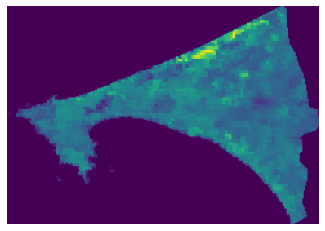

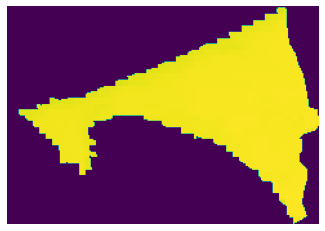

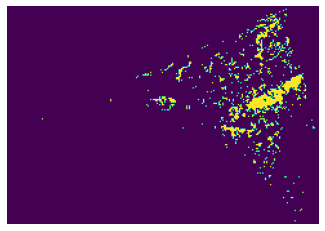

diourbel


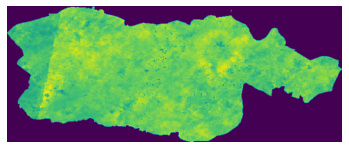

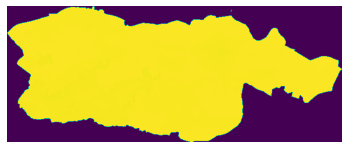

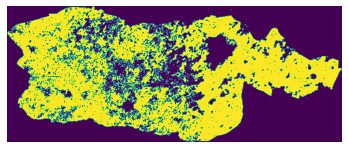

fatick


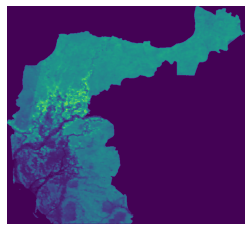

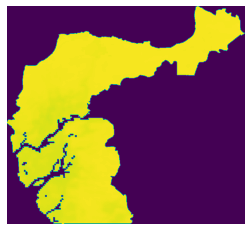

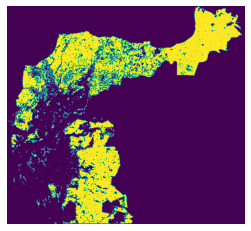

kaffrine


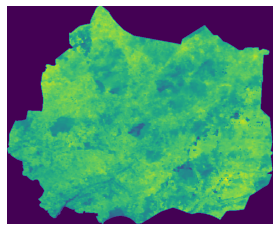

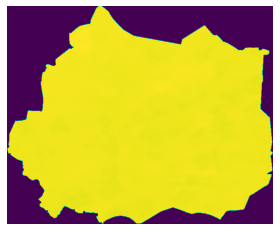

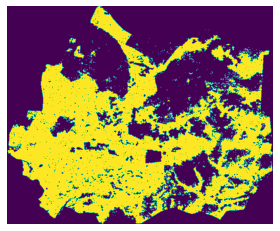

kaolack


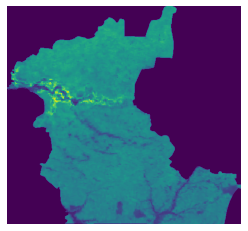

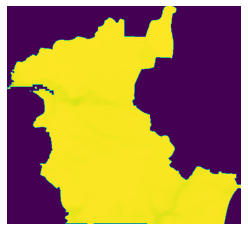

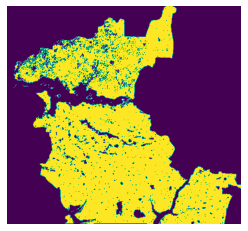

kedougou


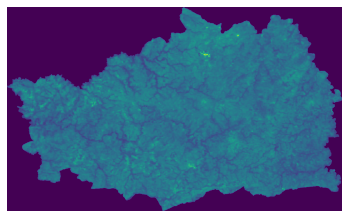

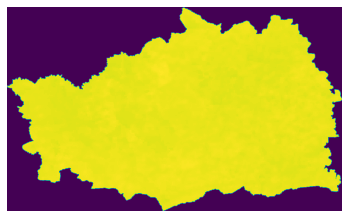

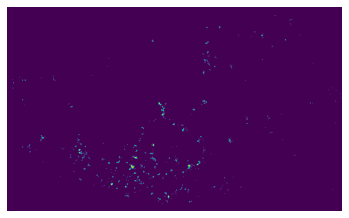

kolda


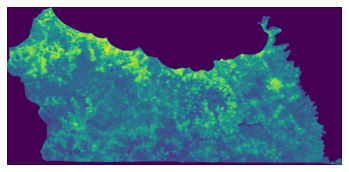

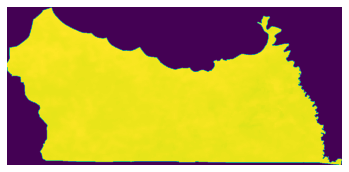

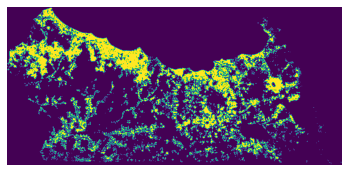

louga


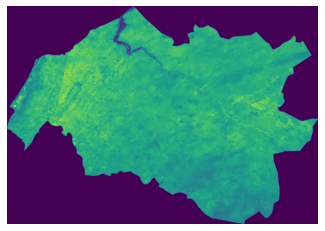

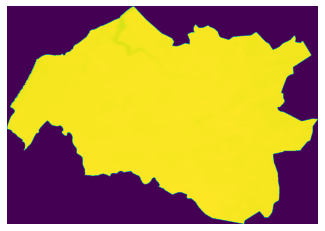

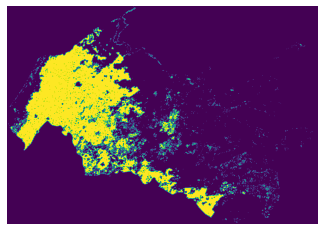

matam


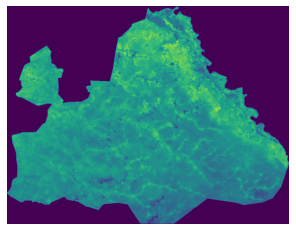

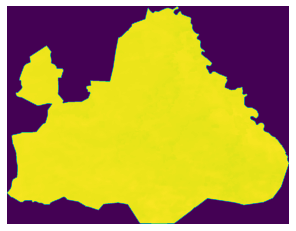

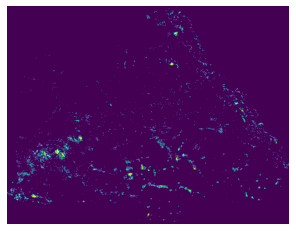

saint-louis


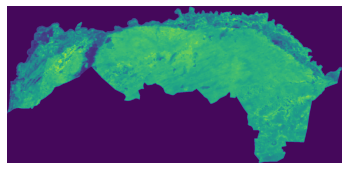

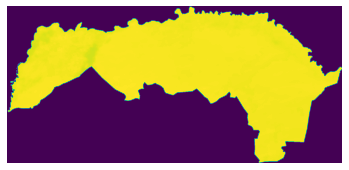

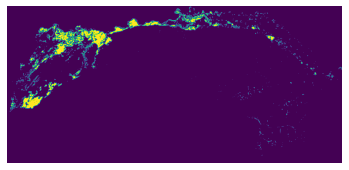

sedhiou


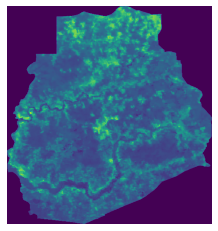

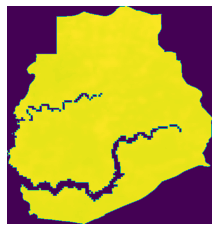

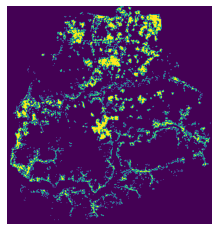

tambacounda


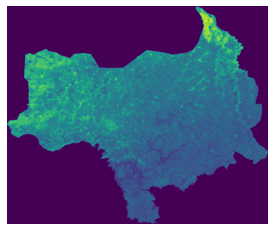

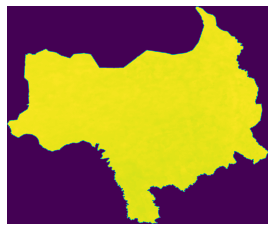

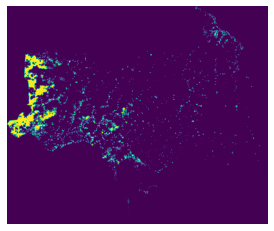

thies


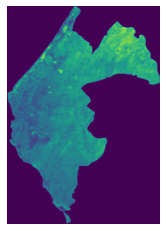

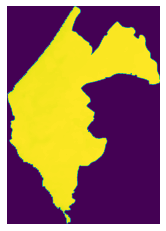

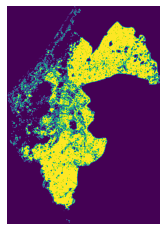

ziguinchor


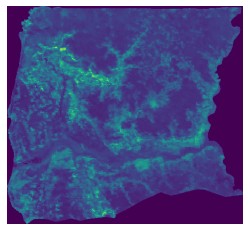

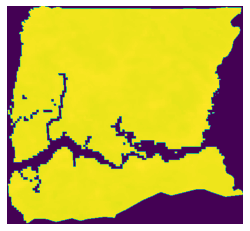

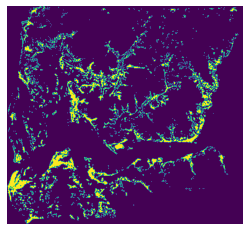

In [50]:
for i in range(len(reflectance_images)):
  print(region_names[i])
  show_first_band_image(reflectance_images[i])
  show_first_band_image(temperature_images[i])
  plt.imshow(landcover_images[i])
  plt.axis('off')
  plt.show()

### Create the dataset: Generate histograms & link them to the ground truth yield values

#### Functions

In [23]:
# functions inspired from https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction

### Function calc_32_bins_histograms ####
# Generates 32-bins pixel counts histograms from GeoTiff
# The resulting histogram's size is [normalized bin values, number of timestamps, band]
# NB: number of timestamps N = N-day composite of GEE layers
# To be able to concanete histograms, all GeoTiff used need to have the same number of timestamps
# otherwise the sizes of the histrograms won't match
#
# Input:
# image: GeoTiff layer
# num_bands : number of bands combined in the image
# bin_seq_list: lindscape list to create the corresponding histograms
# weeks: time in weeks of the months before harvest. for 1 year: weeks = [0,46]
# for first week June to last week August: weeks = [19,30]
def calc_32_bins_histograms(image, num_bands, bin_seq_list, weeks=[0,46]):
    num_bins = 32
    num_times = image.shape[2] // num_bands
    hist = np.zeros([num_bins, num_times, num_bands])
    for i in range(image.shape[2]):
        band = i % num_bands
        density, _ = np.histogram(image[:, :, i], bin_seq_list[band], density=False)
        total = density.sum()  # normalize over only values in bins
        hist[:, i // num_bands, band] = density / float(total) if total > 0 else 0
    return hist[:, weeks[0]:weeks[1]]

#### Function mask_image
# Removes non-crop pixels in all 2D slices of 3D image tensor of shape X x Y x (bands/time)
def mask_image(img, mask, num_bands):
    num_imgs = img.shape[2]//num_bands
    for t in range(num_imgs):
        for b in range(num_bands):
            img[:, :, t*num_bands + b] = np.multiply(img[:, :, t*num_bands + b], mask)
    return img
    
def get_weeks_for_crop_type(crop_type):
  weeks = []
  if crop_type.lower() == "maize":
    weeks = [19,30] # first week of June to last week of August
  if crop_type.lower() == "millet":
    weeks = [21,30] # first week of June to last week of August
  if crop_type.lower() == "rice":
    weeks = [19,30] # first week of June to last week of August
  return weeks

def get_bin_seq_and_num_bands_for_image_collection(image_collection_name):
  print(image_collection_name)
  if image_collection_name == 'reflectance':
    bin_seq_list = [np.linspace(1, 2200, 33),
            np.linspace(900, 4999, 33),
            np.linspace(1, 1250, 33),
            np.linspace(150, 1875, 33),
            np.linspace(750, 4999, 33),
            np.linspace(300, 4999, 33),
            np.linspace(1, 4999, 33)]
    num_bands = 7
  if image_collection_name == 'temperature':
    bin_seq_list = [np.linspace(13000,16500,33), np.linspace(13000,15500,33)]
    num_bands = 2
  return bin_seq_list, num_bands

def get_histograms(image_collection_name, image_img_collection, landcover_mask, crop_type):
  weeks = get_weeks_for_crop_type(crop_type)
  bin_seq, num_bands = get_bin_seq_and_num_bands_for_image_collection(image_collection_name)

  masked_image = mask_image(image_img_collection, landcover_mask, num_bands)
  print("Shape masked image: {}".format(masked_image.shape))
  hist = calc_32_bins_histograms(masked_image, num_bands, bin_seq, weeks)

  print("Shape histogram {}".format(hist.shape))
  plt.suptitle("Histograms")
  for i in range(hist.shape[-1]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(hist[:, :, i])
  plt.show()
  plt.figure(1)
  plt.suptitle('Image cropped and first band histogram')
  plt.subplot(121)
  plt.imshow(masked_image[:, :, 0])
  plt.subplot(122)
  plt.imshow(hist[:, :, 0])
  return hist

#### Generate histograms

In [24]:
crop_type = "Rice"

reflectance
Shape masked image: (169, 242, 322)
Shape histogram (32, 11, 7)


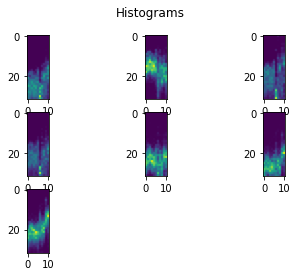

temperature
Shape masked image: (169, 242, 92)
Shape histogram (32, 11, 2)


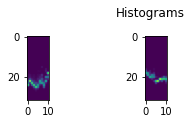

reflectance
Shape masked image: (285, 704, 322)
Shape histogram (32, 11, 7)


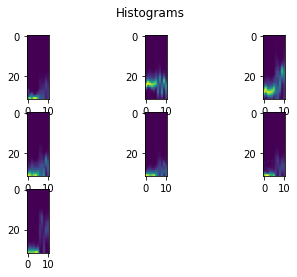

temperature
Shape masked image: (285, 704, 92)
Shape histogram (32, 11, 2)


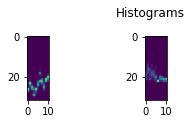

reflectance
Shape masked image: (641, 700, 322)
Shape histogram (32, 11, 7)


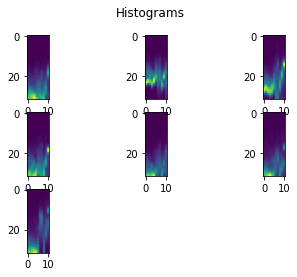

temperature
Shape masked image: (641, 700, 92)
Shape histogram (32, 11, 2)


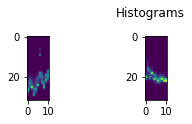

reflectance
Shape masked image: (584, 714, 322)
Shape histogram (32, 11, 7)


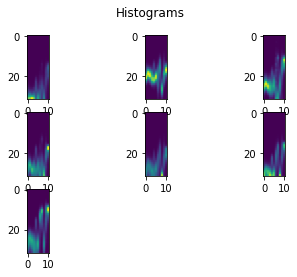

temperature
Shape masked image: (584, 714, 92)
Shape histogram (32, 11, 2)


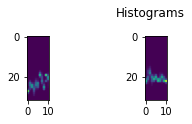

reflectance
Shape masked image: (510, 548, 322)
Shape histogram (32, 11, 7)


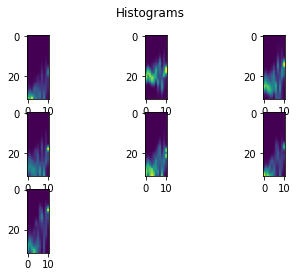

temperature
Shape masked image: (510, 548, 92)
Shape histogram (32, 11, 2)


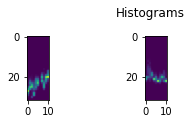

reflectance
Shape masked image: (644, 1057, 322)
Shape histogram (32, 11, 7)


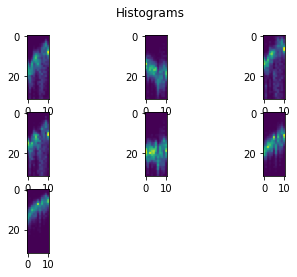

temperature
Shape masked image: (644, 1057, 92)
Shape histogram (32, 11, 2)


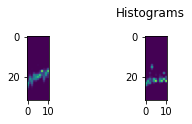

reflectance
Shape masked image: (525, 1114, 322)
Shape histogram (32, 11, 7)


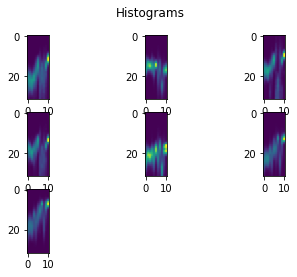

temperature
Shape masked image: (525, 1114, 92)
Shape histogram (32, 11, 2)


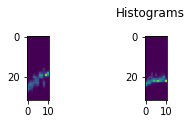

reflectance
Shape masked image: (880, 1258, 322)
Shape histogram (32, 11, 7)


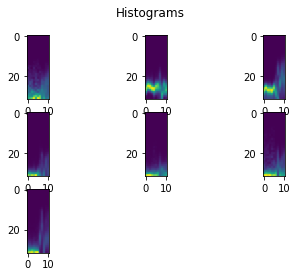

temperature
Shape masked image: (880, 1258, 92)
Shape histogram (32, 11, 2)


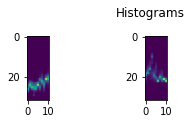

reflectance
Shape masked image: (972, 1259, 322)
Shape histogram (32, 11, 7)


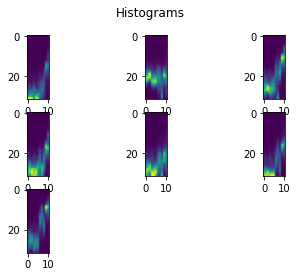

temperature
Shape masked image: (972, 1259, 92)
Shape histogram (32, 11, 2)


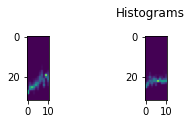

reflectance
Shape masked image: (739, 1581, 322)
Shape histogram (32, 11, 7)


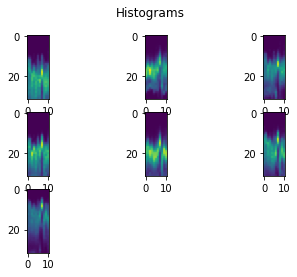

temperature
Shape masked image: (739, 1581, 92)
Shape histogram (32, 11, 2)


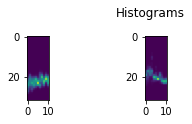

reflectance
Shape masked image: (541, 508, 322)
Shape histogram (32, 11, 7)


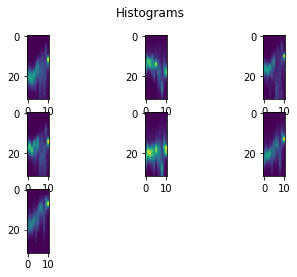

temperature
Shape masked image: (541, 508, 92)
Shape histogram (32, 11, 2)


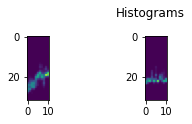

reflectance
Shape masked image: (1384, 1655, 322)
Shape histogram (32, 11, 7)


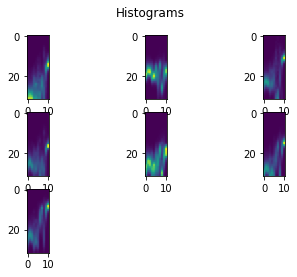

temperature
Shape masked image: (1384, 1655, 92)
Shape histogram (32, 11, 2)


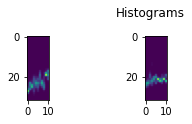

reflectance
Shape masked image: (785, 549, 322)
Shape histogram (32, 11, 7)


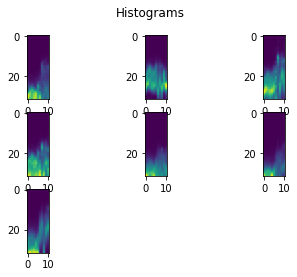

temperature
Shape masked image: (785, 549, 92)
Shape histogram (32, 11, 2)


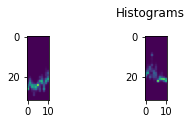

reflectance
Shape masked image: (466, 505, 322)
Shape histogram (32, 11, 7)


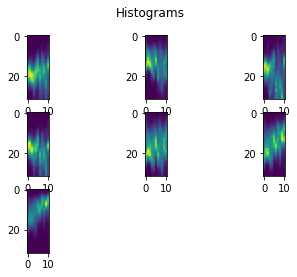

temperature
Shape masked image: (466, 505, 92)
Shape histogram (32, 11, 2)


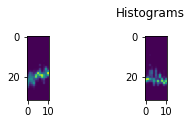

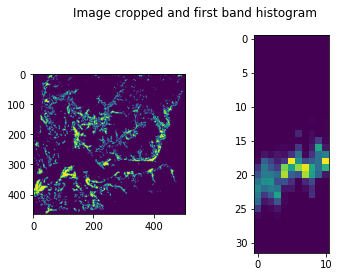

In [107]:
histograms_combined = []
for i in range(len(reflectance_images)):
  hist_reflectance = get_histograms('reflectance', reflectance_images[i], landcover_images[i], crop_type=crop_type)
  hist_temperature = get_histograms('temperature', temperature_images[i], landcover_images[i], crop_type=crop_type)
  # Combine bands of sat and temperature in one array: results in 9 bands
  histogram_combined = np.concatenate((hist_reflectance, hist_temperature), axis=2)
  histograms_combined.append(histogram_combined)
histograms_combined = np.array(histograms_combined)

In [88]:
print(histograms_combined[0].shape)

(32, 11, 9)


#### Link with yield values - [data source](https://senegal.opendataforafrica.org/idtepgd/agriculture-r%C3%A9sultats-des-campagnes-agricoles#) 

In [30]:
# Import file Senegal_yields_regions.csv (in examples repo)
yield_values = pd.read_csv('/content/Senegal_yields_regions.csv')
yield_values = yield_values[yield_values['Yield'] != 0]
yield_values.head(10) 

NumExpr defaulting to 2 threads.


,Region,Year,Crop,Area planted (ha),Production,Yield
9,DAKAR,2019,Peanut,372.0,56.0,0.1650
10,DAKAR,2019,Maize,524.0,105.0,0.2200
11,DAKAR,2018,Cowpea,154.0,61.0,0.4400
12,DAKAR,2019,Cowpea,169.0,68.0,0.4400
13,DAKAR,2017,Cowpea,944.0,15580.0,0.4950
14,DAKAR,2018,Millet,9.0,4.0,0.4950
15,DAKAR,2016,Cowpea,858.0,397.0,0.5093
16,DAKAR,2017,Sorghum,385.0,193.0,0.5500
17,DAKAR,2016,Sorghum,350.0,180.0,0.5665
18,DAKAR,2018,Sorghum,300.0,170.0,0.6215


In [84]:
yield_values_crop_type = yield_values[yield_values['Crop'] == crop_type]
year = int(np.unique(np.array(years_images))[0])
# in this example we only have one year (2016) 
yield_values_crop_type_year = yield_values_crop_type[yield_values_crop_type['Year'] == year]
yield_values_crop_type_year.head(5)

,Region,Year,Crop,Area planted (ha),Production,Yield
105,FATICK,2016,Rice,5684.0,15982.0,3.0932
126,KAFFRINE,2016,Rice,607.0,478.0,0.8657
183,KAOLACK,2016,Rice,1900.0,5525.0,3.1988
220,KEDOUGOU,2016,Rice,7500.0,18750.0,2.7500
264,KOLDA,2016,Rice,58036.0,162964.0,3.0888


In [83]:
# for year in np.unique(np.array(yield_values_crop_type.Year.to_list())):
#   df_real_yields_year = yield_values_crop_type[yield_values_crop_type["Year"] == year]
#   df_real_yields_year_corn = df_real_yields_year[df_real_yields_year["Crop"] == "Rice"]
#   df_real_yields_year_corn.plot.bar(x='Region', y="Yield", figsize=(10,8), title="Rice per department {}".format(year))

Create list yield values corresponding to year and region

In [117]:
yield_values_linked_hists = []
histograms_indexes_to_delete = []
# Link histograms to yield values 
for i in range(len(region_names)):
  if region_names[i].upper() in yield_values_crop_type_year.Region.to_list():
    id = yield_values_crop_type_year.loc[yield_values_crop_type_year.isin([region_names[i].upper()]).any(axis=1)].index.tolist()[0]
    yield_region = yield_values_crop_type_year.Yield.loc[id]
    yield_values_linked_hists.append([yield_region])
    print("Region {}'s yield is {} T/ha".format(region_names[i], yield_region))
  else:
    # remove histograms that has no associated yield values 
    histograms_indexes_to_delete.append(i)

yield_values_linked_hists = np.array(yield_values_linked_hists)
histograms_combined = np.delete(histograms_combined, histograms_indexes_to_delete, axis=0)
assert histograms_combined.shape[0] == yield_values_linked_hists.shape[0]

Region fatick's yield is 3.0932 T/ha
Region kaffrine's yield is 0.8657 T/ha
Region kaolack's yield is 3.1988 T/ha
Region kedougou's yield is 2.75 T/ha
Region kolda's yield is 3.0888 T/ha
Region louga's yield is 1.1 T/ha
Region matam's yield is 7.7 T/ha
Region saint-louis's yield is 7.6923 T/ha
Region sedhiou's yield is 3.1812 T/ha
Region tambacounda's yield is 3.7818 T/ha
Region ziguinchor's yield is 2.3155 T/ha


#### Send dataset to Activeloop

In [90]:
!hub login

Please log in using Activeloop credentials. You can register at https://app.activeloop.ai 
Username: margauxmforsythe
Password: 
Login Successful.


In [118]:
tag = "margauxmforsythe/Senegal_regions_histograms_yields_{}".format(year)
# Create dataset
ds = Dataset(
    tag,
    shape=(histograms_combined.shape[0],),
    schema={
        "histograms": schema.Tensor(histograms_combined[0].shape, dtype="float"),
        "yields": schema.Tensor(shape=(1,), dtype="float"),
    },
    mode="w+",
)

# Upload Data
ds["histograms"][:] = histograms_combined
ds["yields"][:] = yield_values_linked_hists
ds.flush()

# Load the data
print("Load data...")
ds = Dataset(tag)
print(len(ds["histograms"][0].compute()))
print("Done!")

Load data...
32
Done!
